# Libs (run this #1)

In [9]:
from uplift.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# from uplift.datasets import make_radcliffe_surry
# from uplift.metrics import qini_q, uplift_curve, null_uplift_curve, optimal_uplift_curve
# from uplift.metrics import qini_curve
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

from sklearn.base import clone
from sklearn.model_selection import train_test_split

import warnings
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import time



# Data extraction (run this #2)

In [2]:
results = {
    'approach': [],
    'uplift_30%': [],
    'AUQC':[],
    'time':[]
} #dict for results

### dataset for training

In [10]:
#const
import pandas as pd
N_ROWS = 4000000 #number of samples

df_dataset = pd.read_csv("DATASETS/criteo-uplift.csv", nrows = N_ROWS)
# print(df_dataset.head)
df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
})
#fit on 
indices_train = [i for i in range(0,N_ROWS // 2)]
indices_test = [i for i in range(N_ROWS // 2,N_ROWS)]
indices_all =  [i for i in range(N_ROWS)]

#for cross validation
num_folds = 5
indices_train_folds = np.array_split(indices_train, num_folds)
indices_test_folds = np.array_split(indices_test, num_folds)



X_train = df_features.loc[indices_train].values
treatment_train = df_dataset.loc[indices_train,'treatment'].values
visit_train = df_dataset.loc[indices_train,'visit'].values

X_test = df_features.loc[indices_test].values
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values

#this part for class transformation
sumar = 0




### dataset for early stopping

In [11]:
N_ROWS_eval_set = 1000000
df_dataset_eval = pd.read_csv("DATASETS/criteo-uplift.csv",header = 0, nrows = N_ROWS_eval_set, skiprows = 4000000)
main = pd.read_csv("DATASETS/criteo-uplift.csv", nrows = 1)
df_dataset_eval.columns = main.columns


df_features_eval = pd.DataFrame({
    'f0': df_dataset_eval['f0'],
    'f1': df_dataset_eval['f1'],
    'f2': df_dataset_eval['f2'],
    'f3': df_dataset_eval['f3'],
    'f4': df_dataset_eval['f4'],
    'f5': df_dataset_eval['f5'],
    'f6': df_dataset_eval['f6'],
    'f7': df_dataset_eval['f7'],
    'f8': df_dataset_eval['f8'],
    'f9': df_dataset_eval['f9'],
    'f10': df_dataset_eval['f10'],
    'f11': df_dataset_eval['f11'],
})

indices_eval = [i for i in range(0,1000000)]

X_eval = df_features_eval.loc[indices_eval].values
treatment_eval = df_dataset_eval.loc[indices_eval,'treatment'].values
visit_eval = df_dataset_eval.loc[indices_eval,'visit'].values

In [34]:
from pprint import pprint


n_estimators = [int(x) for x in np.linspace(start = 1, stop = 45, num = 5)]
# Number of features to consider at every split
max_features = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [500, 1000, 2000, 5000, 10000]
# Minimum number of samples required at each leaf node
min_samples_leaf = [500, 1000, 2000, 5000, 10000]
# Method of selecting samples for training each tree
#bootstrap = [True, False]


param_grid = {
              'max_features':max_features,
               'min_samples_leaf': min_samples_leaf}

pprint(param_grid)

{'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'min_samples_leaf': [500, 1000, 2000, 5000, 10000]}


In [35]:
from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)



#   Validation

In [84]:
val_count = N_ROWS // num_folds #volume of validation set
train_count = N_ROWS - val_count
print(train_count)

3200000


In [86]:
from uplift.metrics import uplift_at_k,qini_auc_score
accuracy_auqc = {}
accuracy = {}
time = []
best_param = {}
best_param_auqc = {}

indices_all_folds = np.array_split(indices_all, num_folds)
#cross validation
for i in range(num_folds):
    
    x_val = df_features.loc[indices_all_folds[i]].values
    y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
    treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values
    
    
    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(train_count)
    
    x_train = df_features.loc[united].values
    y_train = df_dataset.loc[united, 'visit'].values
    treatment_train = df_dataset.loc[united, 'treatment'].values
    best_acc = 0.0
    best_auqc = 0.0
    for params in grid_list:
        
        rfc = RandomForestClassifier(n_estimators = 10, min_samples_leaf= params["min_samples_leaf"], 
                                     max_features = params["max_features"], max_depth = None, criterion='uplift_gini')
        start_time = datetime.now()
        rfc.fit(x_train,y_train,treatment_train)
        time.append(datetime.now() - start_time)

        pred = rfc.predict_uplift(x_val)
        #acc = np.mean(pred==y_val)
        acc = uplift_at_k(y_true=y_val, uplift=pred, treatment=treatment_val,strategy= "by_group", k=0.3)
        auqc = qini_auc_score(y_true = y_val, uplift=pred, treatment=treatment_val)
        if acc > best_acc:
            accuracy[i] = acc
            best_param[i] = [params["max_features"],params["min_samples_leaf"],  'stat_test']
            print("fold {}, acc {}, params {}".format(i,acc,[params["max_features"],params["min_samples_leaf"],  'uplift_gini']))
            best_acc = acc
        if auqc > best_auqc:
            accuracy_auqc[i] = auqc
            best_param_auqc[i] =  [params["max_features"],params["min_samples_leaf"],  'uplift_gini']
            print("fold {}, auqc {}, params {}".format(i,auqc,[params["max_features"],params["min_samples_leaf"],  'uplift_gini']))
            best_auqc = auqc
            
    
print("best accuracies in folds:")
print(accuracy)
print(accuracy_auqc)


fold 0, acc 0.04855811376035362, params [0.1, 500, 'stat_test']
fold 0, auqc 6498985307.761564, params [0.1, 500, 'stat_test']
fold 0, auqc 7414597314.856168, params [0.1, 1000, 'stat_test']
fold 0, acc 0.054381376560450556, params [0.1, 2000, 'stat_test']
fold 0, auqc 7905828310.120539, params [0.1, 2000, 'stat_test']
fold 0, acc 0.05532685288682773, params [0.1, 5000, 'stat_test']
fold 0, auqc 8421239292.95392, params [0.1, 5000, 'stat_test']
fold 0, acc 0.05661075856110219, params [0.1, 10000, 'stat_test']
fold 0, acc 0.05747982573008731, params [0.3, 10000, 'stat_test']


KeyboardInterrupt: 

In [35]:

ac_30  = np.fromiter(accuracy.values(), dtype=float)
ac_auqc = np.fromiter(accuracy_auqc.values(), dtype=float)

print("mean_30%: {}, mean_auqc: {}, std_30%: {}, std_auqc:{}".format(np.mean(ac_30),
                    np.mean(ac_auqc),np.std(ac_30),np.std(ac_auqc)))

mean_30%: 0.05621954438303188, mean_auqc: 8959685903.665157, std_30%: 0.0009683336505626262, std_auqc:140595918.445673


best accuracies in folds:{0: 0.05434477908756026, 1: 0.059537300098870816, 2: 0.05435936264309783, 3: 0.056576950418883554, 4: 0.056965069986538275}


# Fit

In [65]:
 rfc = RandomForestClassifier(n_estimators = 10, min_samples_leaf= 10000 , 
                                     max_features = 0.4 , max_depth = None, criterion='uplift_gini')

In [68]:
start_time = datetime.now()
rfc.fit(X_train, visit_train, treatment_train)
time_fit = datetime.now() - start_time

In [69]:
uplift_pred = rfc.predict_uplift(X_test)

In [70]:
forest_score = uplift_at_k(y_true=Y_test_visit, uplift=uplift_pred, treatment=treatment_test,strategy= "by_group", k=0.3)
forest_auqc = qini_auc_score(y_true = Y_test_visit, uplift=uplift_pred, treatment=treatment_test)

results['approach'].append('Random_forest')
results['uplift_30%'].append(forest_score)
results['AUQC'].append(forest_auqc)
results['time'].append(time_fit.total_seconds())


D:\WORK\ML_in_trading\uplift-master\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
D:\WORK\ML_in_trading\uplift-master\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000216BA798E80>,
      dtype=object)

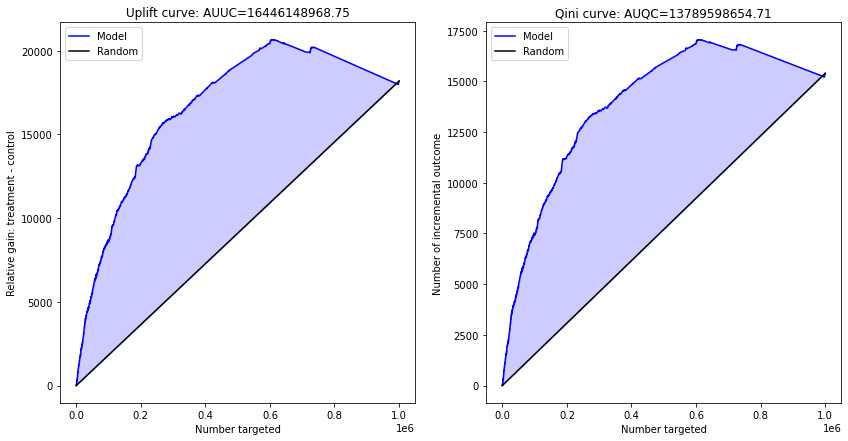

In [11]:
from uplift.vizualization import plot_uplift_preds, plot_uplift_qini_curves
plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_pred, treatment=treatment_test)

# SOLO model


### validation

In [23]:
from pprint import pprint

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 9, num = 5)]



param_grid = {
              'max_depth':max_depth
             }

pprint(param_grid)

{'max_depth': [1, 3, 5, 7, 9]}


In [24]:
from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)


In [25]:
val_count = N_ROWS // num_folds #volume of validation set
train_count = N_ROWS - val_count
print(train_count)

3200000


In [53]:
print(type(df_dataset.loc[1,'visit']))

<class 'numpy.int64'>


In [77]:
from uplift.models import SoloModel
from uplift.metrics import uplift_at_k,qini_auc_score
accuracy_auqc = {}
accuracy = {}
eval_set = [(np.column_stack((X_eval,treatment_eval)), visit_eval)]
best_param = {}
best_param_auqc = {}
indices_eval_folds = np.array_split(indices_eval, num_folds)
#cross validation

for i in range(num_folds):
    
    x_val = df_features.loc[indices_all_folds[i]].values
    y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
    treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values
    
    
    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(train_count)
    
    x_train = df_features.loc[united].values
    y_train = df_dataset.loc[united, 'visit'].values
    treatment_train = df_dataset.loc[united, 'treatment'].values
    best_acc = 0.0
    best_auqc = 0.0
    for params in grid_list:
        
        sm = SoloModel(XGBClassifier(max_depth = params["max_depth"]))
        start_time = datetime.now()
        
        sm = sm.fit(x_train, y_train, treatment_train, estimator_fit_params={'early_stopping_rounds': 10,
                                                'eval_metric':"auc", "eval_set":eval_set})
        time_fit = datetime.now() - start_time

        uplift_sm = sm.predict(x_val)
        
        acc = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val,strategy= "by_group", k=0.3)
        auqc = qini_auc_score(y_true = y_val, uplift=uplift_sm, treatment=treatment_val)
        if acc > best_acc:
            accuracy[i] = acc
            best_param[i] = [params["max_depth"]]
            print("fold {}, acc {}, params {}".format(i,acc,[params["max_depth"]]))
            best_acc = acc
            
        if auqc > best_auqc:
            accuracy_auqc[i] = auqc
            best_param_auqc[i] = [params["max_depth"]]
            print("fold {}, auqc {}, params {}".format(i,auqc,[params["max_depth"]]))
            best_auqc = auqc
            
    
print("best accuracies in folds:")
print(accuracy)
print(accuracy_auqc)
print(best_param)
print(best_param_auqc)

[0]	validation_0-auc:0.76534
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82268
[2]	validation_0-auc:0.84069
[3]	validation_0-auc:0.85923
[4]	validation_0-auc:0.86520
[5]	validation_0-auc:0.87015
[6]	validation_0-auc:0.87628
[7]	validation_0-auc:0.88581
[8]	validation_0-auc:0.88834
[9]	validation_0-auc:0.88870
[10]	validation_0-auc:0.89199
[11]	validation_0-auc:0.89310
[12]	validation_0-auc:0.89339
[13]	validation_0-auc:0.89470
[14]	validation_0-auc:0.89483
[15]	validation_0-auc:0.89515
[16]	validation_0-auc:0.89641
[17]	validation_0-auc:0.89751
[18]	validation_0-auc:0.89800
[19]	validation_0-auc:0.89663
[20]	validation_0-auc:0.89678
[21]	validation_0-auc:0.89658
[22]	validation_0-auc:0.89630
[23]	validation_0-auc:0.89692
[24]	validation_0-auc:0.89647
[25]	validation_0-auc:0.90747
[26]	validation_0-auc:0.90749
[27]	validation_0-auc:0.90791
[28]	validation_0-auc:0.90761
[29]	validation_0-auc:0.90802
[30]	validation_0-auc:0.90909
[31]	validation_

[62]	validation_0-auc:0.92489
[63]	validation_0-auc:0.92489
[64]	validation_0-auc:0.92488
[65]	validation_0-auc:0.92488
[66]	validation_0-auc:0.92494
[67]	validation_0-auc:0.92497
[68]	validation_0-auc:0.92501
[69]	validation_0-auc:0.92504
[70]	validation_0-auc:0.92505
[71]	validation_0-auc:0.92510
[72]	validation_0-auc:0.92513
[73]	validation_0-auc:0.92511
[74]	validation_0-auc:0.92511
[75]	validation_0-auc:0.92514
[76]	validation_0-auc:0.92514
[77]	validation_0-auc:0.92519
[78]	validation_0-auc:0.92522
[79]	validation_0-auc:0.92524
[80]	validation_0-auc:0.92522
[81]	validation_0-auc:0.92524
[82]	validation_0-auc:0.92524
[83]	validation_0-auc:0.92530
[84]	validation_0-auc:0.92530
[85]	validation_0-auc:0.92530
[86]	validation_0-auc:0.92530
[87]	validation_0-auc:0.92530
[88]	validation_0-auc:0.92531
[89]	validation_0-auc:0.92531
[90]	validation_0-auc:0.92532
[91]	validation_0-auc:0.92532
[92]	validation_0-auc:0.92532
[93]	validation_0-auc:0.92532
[94]	validation_0-auc:0.92531
[95]	valid

[38]	validation_0-auc:0.92609
[39]	validation_0-auc:0.92609
Stopping. Best iteration:
[29]	validation_0-auc:0.92614

fold 0, auqc 8722749675.141197, params [7]
[0]	validation_0-auc:0.92139
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92300
[2]	validation_0-auc:0.92405
[3]	validation_0-auc:0.92442
[4]	validation_0-auc:0.92475
[5]	validation_0-auc:0.92480
[6]	validation_0-auc:0.92496
[7]	validation_0-auc:0.92551
[8]	validation_0-auc:0.92566
[9]	validation_0-auc:0.92575
[10]	validation_0-auc:0.92576
[11]	validation_0-auc:0.92581
[12]	validation_0-auc:0.92592
[13]	validation_0-auc:0.92595
[14]	validation_0-auc:0.92592
[15]	validation_0-auc:0.92601
[16]	validation_0-auc:0.92610
[17]	validation_0-auc:0.92609
[18]	validation_0-auc:0.92605
[19]	validation_0-auc:0.92605
[20]	validation_0-auc:0.92608
[21]	validation_0-auc:0.92607
[22]	validation_0-auc:0.92610
[23]	validation_0-auc:0.92612
[24]	validation_0-auc:0.92614
[25]	validation_0-auc:0.92613
[26]	v

[56]	validation_0-auc:0.92471
[57]	validation_0-auc:0.92471
[58]	validation_0-auc:0.92472
[59]	validation_0-auc:0.92470
[60]	validation_0-auc:0.92470
[61]	validation_0-auc:0.92471
[62]	validation_0-auc:0.92471
[63]	validation_0-auc:0.92482
[64]	validation_0-auc:0.92484
[65]	validation_0-auc:0.92484
[66]	validation_0-auc:0.92491
[67]	validation_0-auc:0.92496
[68]	validation_0-auc:0.92502
[69]	validation_0-auc:0.92507
[70]	validation_0-auc:0.92505
[71]	validation_0-auc:0.92505
[72]	validation_0-auc:0.92505
[73]	validation_0-auc:0.92505
[74]	validation_0-auc:0.92506
[75]	validation_0-auc:0.92507
[76]	validation_0-auc:0.92507
[77]	validation_0-auc:0.92507
[78]	validation_0-auc:0.92507
[79]	validation_0-auc:0.92507
[80]	validation_0-auc:0.92511
[81]	validation_0-auc:0.92510
[82]	validation_0-auc:0.92513
[83]	validation_0-auc:0.92511
[84]	validation_0-auc:0.92513
[85]	validation_0-auc:0.92515
[86]	validation_0-auc:0.92515
[87]	validation_0-auc:0.92521
[88]	validation_0-auc:0.92521
[89]	valid

[41]	validation_0-auc:0.92598
[42]	validation_0-auc:0.92598
[43]	validation_0-auc:0.92599
Stopping. Best iteration:
[33]	validation_0-auc:0.92600

fold 1, auqc 8857023871.70494, params [6]
[0]	validation_0-auc:0.91743
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92179
[2]	validation_0-auc:0.92281
[3]	validation_0-auc:0.92369
[4]	validation_0-auc:0.92400
[5]	validation_0-auc:0.92426
[6]	validation_0-auc:0.92458
[7]	validation_0-auc:0.92506
[8]	validation_0-auc:0.92522
[9]	validation_0-auc:0.92534
[10]	validation_0-auc:0.92554
[11]	validation_0-auc:0.92563
[12]	validation_0-auc:0.92566
[13]	validation_0-auc:0.92574
[14]	validation_0-auc:0.92585
[15]	validation_0-auc:0.92581
[16]	validation_0-auc:0.92592
[17]	validation_0-auc:0.92593
[18]	validation_0-auc:0.92591
[19]	validation_0-auc:0.92588
[20]	validation_0-auc:0.92590
[21]	validation_0-auc:0.92599
[22]	validation_0-auc:0.92601
[23]	validation_0-auc:0.92599
[24]	validation_0-auc:0.92597
[25]	va

[65]	validation_0-auc:0.92265
[66]	validation_0-auc:0.92264
[67]	validation_0-auc:0.92265
[68]	validation_0-auc:0.92261
[69]	validation_0-auc:0.92264
[70]	validation_0-auc:0.92268
[71]	validation_0-auc:0.92268
[72]	validation_0-auc:0.92270
[73]	validation_0-auc:0.92270
[74]	validation_0-auc:0.92273
[75]	validation_0-auc:0.92274
[76]	validation_0-auc:0.92275
[77]	validation_0-auc:0.92275
[78]	validation_0-auc:0.92276
[79]	validation_0-auc:0.92279
[80]	validation_0-auc:0.92280
[81]	validation_0-auc:0.92285
[82]	validation_0-auc:0.92288
[83]	validation_0-auc:0.92289
[84]	validation_0-auc:0.92289
[85]	validation_0-auc:0.92289
[86]	validation_0-auc:0.92291
[87]	validation_0-auc:0.92293
[88]	validation_0-auc:0.92305
[89]	validation_0-auc:0.92307
[90]	validation_0-auc:0.92306
[91]	validation_0-auc:0.92307
[92]	validation_0-auc:0.92309
[93]	validation_0-auc:0.92311
[94]	validation_0-auc:0.92312
[95]	validation_0-auc:0.92312
[96]	validation_0-auc:0.92312
[97]	validation_0-auc:0.92314
[98]	valid

[29]	validation_0-auc:0.92565
[30]	validation_0-auc:0.92564
[31]	validation_0-auc:0.92565
[32]	validation_0-auc:0.92565
[33]	validation_0-auc:0.92565
[34]	validation_0-auc:0.92567
[35]	validation_0-auc:0.92567
[36]	validation_0-auc:0.92571
[37]	validation_0-auc:0.92572
[38]	validation_0-auc:0.92572
[39]	validation_0-auc:0.92575
[40]	validation_0-auc:0.92575
[41]	validation_0-auc:0.92575
[42]	validation_0-auc:0.92576
[43]	validation_0-auc:0.92576
[44]	validation_0-auc:0.92576
[45]	validation_0-auc:0.92578
[46]	validation_0-auc:0.92580
[47]	validation_0-auc:0.92579
[48]	validation_0-auc:0.92579
[49]	validation_0-auc:0.92579
[50]	validation_0-auc:0.92579
[51]	validation_0-auc:0.92579
[52]	validation_0-auc:0.92580
[53]	validation_0-auc:0.92583
[54]	validation_0-auc:0.92585
[55]	validation_0-auc:0.92586
[56]	validation_0-auc:0.92586
[57]	validation_0-auc:0.92585
[58]	validation_0-auc:0.92585
[59]	validation_0-auc:0.92585
[60]	validation_0-auc:0.92585
[61]	validation_0-auc:0.92587
[62]	valid

[73]	validation_0-auc:0.91163
[74]	validation_0-auc:0.91165
[75]	validation_0-auc:0.91163
[76]	validation_0-auc:0.91168
[77]	validation_0-auc:0.91172
[78]	validation_0-auc:0.91172
[79]	validation_0-auc:0.91160
[80]	validation_0-auc:0.91163
[81]	validation_0-auc:0.91182
[82]	validation_0-auc:0.91167
[83]	validation_0-auc:0.91169
[84]	validation_0-auc:0.91175
[85]	validation_0-auc:0.91160
[86]	validation_0-auc:0.91184
[87]	validation_0-auc:0.91184
[88]	validation_0-auc:0.91186
[89]	validation_0-auc:0.91209
[90]	validation_0-auc:0.91190
[91]	validation_0-auc:0.91211
[92]	validation_0-auc:0.91219
[93]	validation_0-auc:0.91221
[94]	validation_0-auc:0.91200
[95]	validation_0-auc:0.91201
[96]	validation_0-auc:0.91209
[97]	validation_0-auc:0.91207
[98]	validation_0-auc:0.91216
[99]	validation_0-auc:0.91213
fold 3, acc 0.05809596143310715, params [1]
fold 3, auqc 6858855468.348461, params [1]
[0]	validation_0-auc:0.84879
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	valida

[35]	validation_0-auc:0.92504
[36]	validation_0-auc:0.92504
[37]	validation_0-auc:0.92504
[38]	validation_0-auc:0.92539
[39]	validation_0-auc:0.92540
[40]	validation_0-auc:0.92542
[41]	validation_0-auc:0.92543
[42]	validation_0-auc:0.92544
[43]	validation_0-auc:0.92542
[44]	validation_0-auc:0.92546
[45]	validation_0-auc:0.92551
[46]	validation_0-auc:0.92553
[47]	validation_0-auc:0.92553
[48]	validation_0-auc:0.92553
[49]	validation_0-auc:0.92553
[50]	validation_0-auc:0.92556
[51]	validation_0-auc:0.92556
[52]	validation_0-auc:0.92556
[53]	validation_0-auc:0.92558
[54]	validation_0-auc:0.92558
[55]	validation_0-auc:0.92560
[56]	validation_0-auc:0.92560
[57]	validation_0-auc:0.92560
[58]	validation_0-auc:0.92560
[59]	validation_0-auc:0.92561
[60]	validation_0-auc:0.92558
[61]	validation_0-auc:0.92555
[62]	validation_0-auc:0.92556
[63]	validation_0-auc:0.92556
[64]	validation_0-auc:0.92556
[65]	validation_0-auc:0.92557
[66]	validation_0-auc:0.92557
[67]	validation_0-auc:0.92557
[68]	valid

[7]	validation_0-auc:0.88587
[8]	validation_0-auc:0.88840
[9]	validation_0-auc:0.88872
[10]	validation_0-auc:0.88967
[11]	validation_0-auc:0.89297
[12]	validation_0-auc:0.89320
[13]	validation_0-auc:0.89451
[14]	validation_0-auc:0.89495
[15]	validation_0-auc:0.89508
[16]	validation_0-auc:0.89635
[17]	validation_0-auc:0.89746
[18]	validation_0-auc:0.89795
[19]	validation_0-auc:0.89660
[20]	validation_0-auc:0.89673
[21]	validation_0-auc:0.89654
[22]	validation_0-auc:0.89625
[23]	validation_0-auc:0.89685
[24]	validation_0-auc:0.89642
[25]	validation_0-auc:0.90742
[26]	validation_0-auc:0.90746
[27]	validation_0-auc:0.90788
[28]	validation_0-auc:0.90684
[29]	validation_0-auc:0.90811
[30]	validation_0-auc:0.90837
[31]	validation_0-auc:0.90749
[32]	validation_0-auc:0.90850
[33]	validation_0-auc:0.90830
[34]	validation_0-auc:0.90771
[35]	validation_0-auc:0.90835
[36]	validation_0-auc:0.90841
[37]	validation_0-auc:0.90849
[38]	validation_0-auc:0.90849
[39]	validation_0-auc:0.91057
[40]	validati

[71]	validation_0-auc:0.92502
[72]	validation_0-auc:0.92509
[73]	validation_0-auc:0.92510
[74]	validation_0-auc:0.92511
[75]	validation_0-auc:0.92514
[76]	validation_0-auc:0.92514
[77]	validation_0-auc:0.92513
[78]	validation_0-auc:0.92514
[79]	validation_0-auc:0.92513
[80]	validation_0-auc:0.92515
[81]	validation_0-auc:0.92517
[82]	validation_0-auc:0.92517
[83]	validation_0-auc:0.92515
[84]	validation_0-auc:0.92515
[85]	validation_0-auc:0.92515
[86]	validation_0-auc:0.92515
[87]	validation_0-auc:0.92516
[88]	validation_0-auc:0.92516
[89]	validation_0-auc:0.92516
[90]	validation_0-auc:0.92518
[91]	validation_0-auc:0.92519
[92]	validation_0-auc:0.92525
[93]	validation_0-auc:0.92528
[94]	validation_0-auc:0.92527
[95]	validation_0-auc:0.92526
[96]	validation_0-auc:0.92530
[97]	validation_0-auc:0.92530
[98]	validation_0-auc:0.92529
[99]	validation_0-auc:0.92532
fold 4, auqc 8516083081.258951, params [3]
[0]	validation_0-auc:0.90234
Will train until validation_0-auc hasn't improved in 10 ro

[26]	validation_0-auc:0.92605
[27]	validation_0-auc:0.92603
[28]	validation_0-auc:0.92602
[29]	validation_0-auc:0.92602
[30]	validation_0-auc:0.92603
[31]	validation_0-auc:0.92605
[32]	validation_0-auc:0.92604
[33]	validation_0-auc:0.92604
[34]	validation_0-auc:0.92606
Stopping. Best iteration:
[24]	validation_0-auc:0.92612

[0]	validation_0-auc:0.92086
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92365
[2]	validation_0-auc:0.92409
[3]	validation_0-auc:0.92463
[4]	validation_0-auc:0.92504
[5]	validation_0-auc:0.92508
[6]	validation_0-auc:0.92513
[7]	validation_0-auc:0.92554
[8]	validation_0-auc:0.92572
[9]	validation_0-auc:0.92577
[10]	validation_0-auc:0.92582
[11]	validation_0-auc:0.92584
[12]	validation_0-auc:0.92592
[13]	validation_0-auc:0.92598
[14]	validation_0-auc:0.92603
[15]	validation_0-auc:0.92599
[16]	validation_0-auc:0.92601
[17]	validation_0-auc:0.92602
[18]	validation_0-auc:0.92604
[19]	validation_0-auc:0.92598
[20]	validation_0-a

In [79]:
ac_30  = np.fromiter(accuracy.values(), dtype=float)
ac_auqc = np.fromiter(accuracy_auqc.values(), dtype=float)

print("mean_30%: {}, mean_auqc: {}, std_30%: {}, std_auqc:{}".format(np.mean(ac_30),
                    np.mean(ac_auqc),np.std(ac_30),np.std(ac_auqc)))

mean_30%: 0.05750370482046633, mean_auqc: 8695405968.931911, std_30%: 0.0007426022289337294, std_auqc:135493054.31704882


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from uplift.models import SoloModel
from uplift.metrics import uplift_at_k, qini_auc_score





sm = SoloModel(XGBClassifier(n_estimators=41))
start_time = datetime.now()
eval_set = [(np.column_stack((X_test,treatment_test)), Y_test_visit)]
sm = sm.fit(X_train, visit_train, treatment_train,estimator_fit_params={'early_stopping_rounds': 10,'eval_metric':"auc", "eval_set":eval_set})
time_fit = datetime.now() - start_time

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=Y_test_visit, uplift=uplift_sm, treatment=treatment_test,strategy='by_group', k=0.3)
auqc = qini_auc_score(y_true = Y_test_visit, uplift=uplift_sm, treatment=treatment_test)

results['approach'].append('SoloModel')
results['uplift_30%'].append(sm_score)
results['AUQC'].append(auqc)
results['time'].append(time_fit.total_seconds())


[0]	validation_0-auc:0.91522
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91744
[2]	validation_0-auc:0.91924
[3]	validation_0-auc:0.91969
[4]	validation_0-auc:0.92091
[5]	validation_0-auc:0.92115
[6]	validation_0-auc:0.92256
[7]	validation_0-auc:0.92335
[8]	validation_0-auc:0.92380
[9]	validation_0-auc:0.92396
[10]	validation_0-auc:0.92426
[11]	validation_0-auc:0.92487
[12]	validation_0-auc:0.92499
[13]	validation_0-auc:0.92504
[14]	validation_0-auc:0.92536
[15]	validation_0-auc:0.92541
[16]	validation_0-auc:0.92552
[17]	validation_0-auc:0.92556
[18]	validation_0-auc:0.92558
[19]	validation_0-auc:0.92559
[20]	validation_0-auc:0.92558
[21]	validation_0-auc:0.92561
[22]	validation_0-auc:0.92562
[23]	validation_0-auc:0.92568
[24]	validation_0-auc:0.92571
[25]	validation_0-auc:0.92574
[26]	validation_0-auc:0.92580
[27]	validation_0-auc:0.92578
[28]	validation_0-auc:0.92579
[29]	validation_0-auc:0.92578
[30]	validation_0-auc:0.92578
[31]	validation_

{'approach': ['SoloModel'], 'uplift_30%': [0.055158659153210624], 'AUQC': [54365039583.501335], 'time': [122.629134]}


D:\WORK\ML_in_trading\uplift-master\uplift\metrics\ranking.py:258: FutureWarning: Metric `auuc` was renamed to `uplift_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(
D:\WORK\ML_in_trading\uplift-master\uplift\metrics\ranking.py:293: FutureWarning: Metric `auqc` was renamed to `qini_auc_score`in version 0.1.0 and will be removed in 0.2.0
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000202FBAB06D0>,
      dtype=object)

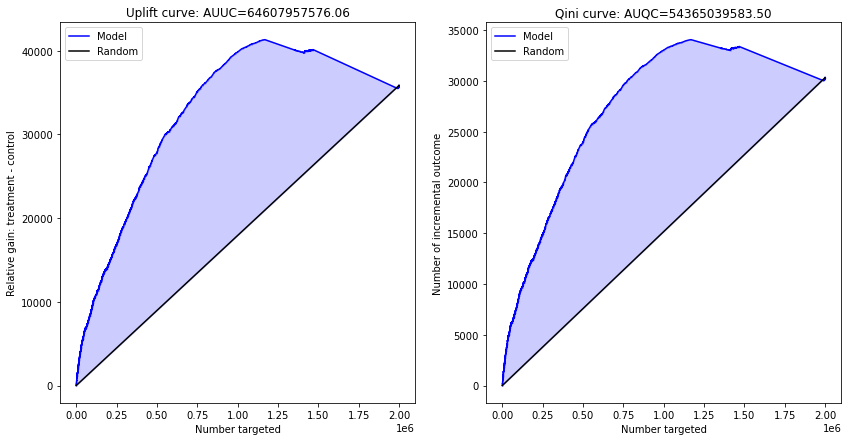

In [15]:

sm = SoloModel(XGBClassifier(n_estimators=41))
from uplift.vizualization import plot_uplift_preds, plot_uplift_qini_curves
plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_sm, treatment=treatment_test)

In [17]:
print(results)

{'approach': ['SoloModel', 'SoloModel'], 'uplift_30%': [0.055158659153210624, 0.10052712128769142], 'AUQC': [54365039583.501335, 54365039583.501335], 'time': [122.629134, 125.690928]}


# TwoModels independent

In [30]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
accuracy_auqc = {}
accuracy = {}
eval_set = [(X_eval, visit_eval)]
best_param = {}
best_param_auqc = {}
time = []
ct_30 = []
ct_auqc = []
indices_eval_folds = np.array_split(indices_eval, num_folds)
indices_all_folds = np.array_split(indices_all, num_folds)
#cross validation

for i in range(num_folds):
    
    x_val = df_features.loc[indices_all_folds[i]].values
    y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
    treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values
    
    
    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(train_count)
    
    x_train = df_features.loc[united].values
    y_train = df_dataset.loc[united, 'visit'].values
    treatment_train = df_dataset.loc[united, 'treatment'].values
    best_acc = 0.0
    best_auqc = 0.0
    for params in grid_list:
        
        tm = TwoModels(
                estimator_trmnt=XGBClassifier(max_depth = params["max_depth"]), 
                estimator_ctrl=XGBClassifier(max_depth = params["max_depth"]), 
                method='vanilla')
        
        start_time = datetime.now()
        
        tm = tm.fit(x_train, y_train, treatment_train, estimator_trmnt_fit_params={'early_stopping_rounds': 10,
                                                'eval_metric':"auc", "eval_set":eval_set},
                                  estimator_ctrl_fit_params ={'early_stopping_rounds': 10,
                                                'eval_metric':"auc", "eval_set":eval_set})
        time.append(datetime.now() - start_time)

        uplift_tm = tm.predict(x_val)
        
        acc = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val,strategy= "by_group", k=0.3)
        auqc = qini_auc_score(y_true = y_val, uplift=uplift_tm, treatment=treatment_val)
        ct_30.append(acc)
        ct_auqc.append(auqc)
        if acc > best_acc:
            accuracy[i] = acc
            best_param[i] = [params["max_depth"]]
            print("fold {}, acc {}, params {}".format(i,acc,[params["max_depth"]]))
            best_acc = acc
            
        if auqc > best_auqc:
            accuracy_auqc[i] = auqc
            best_param_auqc[i] = [params["max_depth"]]
            print("fold {}, auqc {}, params {}".format(i,auqc,[params["max_depth"]]))
            best_auqc = auqc
            
    
print("best accuracies in folds:")
print(accuracy)
print(accuracy_auqc)
print(best_param)
print(best_param_auqc)






[0]	validation_0-auc:0.76670
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81628
[2]	validation_0-auc:0.83289
[3]	validation_0-auc:0.85267
[4]	validation_0-auc:0.85834
[5]	validation_0-auc:0.86775
[6]	validation_0-auc:0.87397
[7]	validation_0-auc:0.87839
[8]	validation_0-auc:0.88222
[9]	validation_0-auc:0.88743
[10]	validation_0-auc:0.89109
[11]	validation_0-auc:0.89138
[12]	validation_0-auc:0.89245
[13]	validation_0-auc:0.89324
[14]	validation_0-auc:0.89343
[15]	validation_0-auc:0.89351
[16]	validation_0-auc:0.89381
[17]	validation_0-auc:0.90843
[18]	validation_0-auc:0.90982
[19]	validation_0-auc:0.91105
[20]	validation_0-auc:0.90734
[21]	validation_0-auc:0.90844
[22]	validation_0-auc:0.91133
[23]	validation_0-auc:0.90787
[24]	validation_0-auc:0.90786
[25]	validation_0-auc:0.90879
[26]	validation_0-auc:0.90802
[27]	validation_0-auc:0.90934
[28]	validation_0-auc:0.91014
[29]	validation_0-auc:0.90960
[30]	validation_0-auc:0.90960
[31]	validation_

Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91394
[2]	validation_0-auc:0.91516
[3]	validation_0-auc:0.91551
[4]	validation_0-auc:0.91818
[5]	validation_0-auc:0.91875
[6]	validation_0-auc:0.91888
[7]	validation_0-auc:0.91988
[8]	validation_0-auc:0.92007
[9]	validation_0-auc:0.92205
[10]	validation_0-auc:0.92264
[11]	validation_0-auc:0.92392
[12]	validation_0-auc:0.92402
[13]	validation_0-auc:0.92445
[14]	validation_0-auc:0.92461
[15]	validation_0-auc:0.92474
[16]	validation_0-auc:0.92475
[17]	validation_0-auc:0.92484
[18]	validation_0-auc:0.92492
[19]	validation_0-auc:0.92492
[20]	validation_0-auc:0.92488
[21]	validation_0-auc:0.92503
[22]	validation_0-auc:0.92505
[23]	validation_0-auc:0.92505
[24]	validation_0-auc:0.92508
[25]	validation_0-auc:0.92512
[26]	validation_0-auc:0.92517
[27]	validation_0-auc:0.92519
[28]	validation_0-auc:0.92520
[29]	validation_0-auc:0.92524
[30]	validation_0-auc:0.92526
[31]	validation_0-auc:0.92526
[32]	validation

[24]	validation_0-auc:0.89677
[25]	validation_0-auc:0.89679
[26]	validation_0-auc:0.89748
[27]	validation_0-auc:0.90782
[28]	validation_0-auc:0.90843
[29]	validation_0-auc:0.90792
[30]	validation_0-auc:0.90806
[31]	validation_0-auc:0.90760
[32]	validation_0-auc:0.90829
[33]	validation_0-auc:0.90851
[34]	validation_0-auc:0.90863
[35]	validation_0-auc:0.90817
[36]	validation_0-auc:0.90822
[37]	validation_0-auc:0.90882
[38]	validation_0-auc:0.90883
[39]	validation_0-auc:0.90887
[40]	validation_0-auc:0.90866
[41]	validation_0-auc:0.90874
[42]	validation_0-auc:0.91014
[43]	validation_0-auc:0.91016
[44]	validation_0-auc:0.91021
[45]	validation_0-auc:0.91060
[46]	validation_0-auc:0.91058
[47]	validation_0-auc:0.91033
[48]	validation_0-auc:0.91037
[49]	validation_0-auc:0.91069
[50]	validation_0-auc:0.91008
[51]	validation_0-auc:0.90953
[52]	validation_0-auc:0.91015
[53]	validation_0-auc:0.91017
[54]	validation_0-auc:0.91011
[55]	validation_0-auc:0.91046
[56]	validation_0-auc:0.91046
[57]	valid

Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91644
[2]	validation_0-auc:0.91770
[3]	validation_0-auc:0.91802
[4]	validation_0-auc:0.91861
[5]	validation_0-auc:0.91892
[6]	validation_0-auc:0.91922
[7]	validation_0-auc:0.91992
[8]	validation_0-auc:0.92032
[9]	validation_0-auc:0.92044
[10]	validation_0-auc:0.92082
[11]	validation_0-auc:0.92049
[12]	validation_0-auc:0.92041
[13]	validation_0-auc:0.92051
[14]	validation_0-auc:0.92064
[15]	validation_0-auc:0.92070
[16]	validation_0-auc:0.92071
[17]	validation_0-auc:0.92057
[18]	validation_0-auc:0.92060
[19]	validation_0-auc:0.92053
[20]	validation_0-auc:0.92049
Stopping. Best iteration:
[10]	validation_0-auc:0.92082

[0]	validation_0-auc:0.91785
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92063
[2]	validation_0-auc:0.92306
[3]	validation_0-auc:0.92356
[4]	validation_0-auc:0.92414
[5]	validation_0-auc:0.92438
[6]	validation_0-auc:0.92438
[7]	validation_0-auc:

[8]	validation_0-auc:0.91311
[9]	validation_0-auc:0.91484
[10]	validation_0-auc:0.91607
[11]	validation_0-auc:0.91653
[12]	validation_0-auc:0.91703
[13]	validation_0-auc:0.91723
[14]	validation_0-auc:0.91719
[15]	validation_0-auc:0.91760
[16]	validation_0-auc:0.91768
[17]	validation_0-auc:0.91788
[18]	validation_0-auc:0.91881
[19]	validation_0-auc:0.91832
[20]	validation_0-auc:0.91845
[21]	validation_0-auc:0.91924
[22]	validation_0-auc:0.91955
[23]	validation_0-auc:0.91973
[24]	validation_0-auc:0.91965
[25]	validation_0-auc:0.91969
[26]	validation_0-auc:0.91967
[27]	validation_0-auc:0.91976
[28]	validation_0-auc:0.91982
[29]	validation_0-auc:0.91981
[30]	validation_0-auc:0.91966
[31]	validation_0-auc:0.91967
[32]	validation_0-auc:0.91966
[33]	validation_0-auc:0.91961
[34]	validation_0-auc:0.91961
[35]	validation_0-auc:0.91963
[36]	validation_0-auc:0.91959
[37]	validation_0-auc:0.91952
[38]	validation_0-auc:0.91953
Stopping. Best iteration:
[28]	validation_0-auc:0.91982

[0]	validation_

[14]	validation_0-auc:0.92551
[15]	validation_0-auc:0.92557
[16]	validation_0-auc:0.92560
[17]	validation_0-auc:0.92556
[18]	validation_0-auc:0.92552
[19]	validation_0-auc:0.92551
[20]	validation_0-auc:0.92555
[21]	validation_0-auc:0.92557
[22]	validation_0-auc:0.92559
[23]	validation_0-auc:0.92561
[24]	validation_0-auc:0.92560
[25]	validation_0-auc:0.92560
[26]	validation_0-auc:0.92556
[27]	validation_0-auc:0.92556
[28]	validation_0-auc:0.92555
[29]	validation_0-auc:0.92556
[30]	validation_0-auc:0.92555
[31]	validation_0-auc:0.92556
[32]	validation_0-auc:0.92553
[33]	validation_0-auc:0.92553
Stopping. Best iteration:
[23]	validation_0-auc:0.92561

[0]	validation_0-auc:0.91321
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91451
[2]	validation_0-auc:0.91553
[3]	validation_0-auc:0.91653
[4]	validation_0-auc:0.91738
[5]	validation_0-auc:0.91801
[6]	validation_0-auc:0.91829
[7]	validation_0-auc:0.91807
[8]	validation_0-auc:0.91866
[9]	validation_0-a

[0]	validation_0-auc:0.88100
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.90810
[2]	validation_0-auc:0.91044
[3]	validation_0-auc:0.91094
[4]	validation_0-auc:0.91106
[5]	validation_0-auc:0.91166
[6]	validation_0-auc:0.91287
[7]	validation_0-auc:0.91272
[8]	validation_0-auc:0.91437
[9]	validation_0-auc:0.91493
[10]	validation_0-auc:0.91734
[11]	validation_0-auc:0.91839
[12]	validation_0-auc:0.91797
[13]	validation_0-auc:0.91836
[14]	validation_0-auc:0.92012
[15]	validation_0-auc:0.92044
[16]	validation_0-auc:0.92131
[17]	validation_0-auc:0.92139
[18]	validation_0-auc:0.92162
[19]	validation_0-auc:0.92185
[20]	validation_0-auc:0.92240
[21]	validation_0-auc:0.92291
[22]	validation_0-auc:0.92293
[23]	validation_0-auc:0.92297
[24]	validation_0-auc:0.92316
[25]	validation_0-auc:0.92328
[26]	validation_0-auc:0.92336
[27]	validation_0-auc:0.92347
[28]	validation_0-auc:0.92352
[29]	validation_0-auc:0.92352
[30]	validation_0-auc:0.92353
[31]	validation_

[11]	validation_0-auc:0.91928
[12]	validation_0-auc:0.91921
[13]	validation_0-auc:0.91958
[14]	validation_0-auc:0.91951
[15]	validation_0-auc:0.91923
[16]	validation_0-auc:0.91909
[17]	validation_0-auc:0.91897
[18]	validation_0-auc:0.91893
[19]	validation_0-auc:0.91885
[20]	validation_0-auc:0.91878
[21]	validation_0-auc:0.91860
[22]	validation_0-auc:0.91848
[23]	validation_0-auc:0.91838
Stopping. Best iteration:
[13]	validation_0-auc:0.91958

[0]	validation_0-auc:0.92269
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92369
[2]	validation_0-auc:0.92412
[3]	validation_0-auc:0.92460
[4]	validation_0-auc:0.92504
[5]	validation_0-auc:0.92509
[6]	validation_0-auc:0.92528
[7]	validation_0-auc:0.92530
[8]	validation_0-auc:0.92537
[9]	validation_0-auc:0.92527
[10]	validation_0-auc:0.92540
[11]	validation_0-auc:0.92543
[12]	validation_0-auc:0.92542
[13]	validation_0-auc:0.92538
[14]	validation_0-auc:0.92538
[15]	validation_0-auc:0.92534
[16]	validation_0-a

[39]	validation_0-auc:0.92382
[40]	validation_0-auc:0.92382
[41]	validation_0-auc:0.92385
[42]	validation_0-auc:0.92384
[43]	validation_0-auc:0.92386
[44]	validation_0-auc:0.92386
[45]	validation_0-auc:0.92399
[46]	validation_0-auc:0.92405
[47]	validation_0-auc:0.92409
[48]	validation_0-auc:0.92409
[49]	validation_0-auc:0.92409
[50]	validation_0-auc:0.92409
[51]	validation_0-auc:0.92414
[52]	validation_0-auc:0.92415
[53]	validation_0-auc:0.92417
[54]	validation_0-auc:0.92417
[55]	validation_0-auc:0.92420
[56]	validation_0-auc:0.92420
[57]	validation_0-auc:0.92421
[58]	validation_0-auc:0.92442
[59]	validation_0-auc:0.92441
[60]	validation_0-auc:0.92441
[61]	validation_0-auc:0.92441
[62]	validation_0-auc:0.92443
[63]	validation_0-auc:0.92441
[64]	validation_0-auc:0.92442
[65]	validation_0-auc:0.92442
[66]	validation_0-auc:0.92442
[67]	validation_0-auc:0.92442
[68]	validation_0-auc:0.92442
[69]	validation_0-auc:0.92442
[70]	validation_0-auc:0.92446
[71]	validation_0-auc:0.92449
[72]	valid

[8]	validation_0-auc:0.92541
[9]	validation_0-auc:0.92547
[10]	validation_0-auc:0.92543
[11]	validation_0-auc:0.92541
[12]	validation_0-auc:0.92552
[13]	validation_0-auc:0.92552
[14]	validation_0-auc:0.92543
[15]	validation_0-auc:0.92539
[16]	validation_0-auc:0.92534
[17]	validation_0-auc:0.92531
[18]	validation_0-auc:0.92528
[19]	validation_0-auc:0.92523
[20]	validation_0-auc:0.92524
[21]	validation_0-auc:0.92519
[22]	validation_0-auc:0.92521
Stopping. Best iteration:
[12]	validation_0-auc:0.92552

best accuracies in folds:
{0: 0.05253109735402608, 1: 0.05007603973687926, 2: 0.05088820029708804, 3: 0.05114795845477361, 4: 0.04933932992224701}
{0: 8096157850.062275, 1: 7806887521.084922, 2: 7886868850.435493, 3: 7833874770.967815, 4: 7805160124.336723}
{0: [1], 1: [3], 2: [1], 3: [1], 4: [5]}
{0: [5], 1: [3], 2: [3], 3: [3], 4: [3]}


In [31]:
ac_30  = np.fromiter(accuracy.values(), dtype=float)
ac_auqc = np.fromiter(accuracy_auqc.values(), dtype=float)

print("mean_30%: {}, mean_auqc: {}, std_30%: {}, std_auqc:{},time:{}".format(np.mean(ac_30),
                    np.mean(ac_auqc),np.std(ac_30),np.std(ac_auqc),np.mean(time)))

mean_30%: 0.05079652515300279, mean_auqc: 7885789823.377446, std_30%: 0.0010754689761758311, std_auqc:109249956.7888372,time:0:02:17.975177


# TwoModels dependent first control

In [22]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
accuracy_auqc = {}
accuracy = {}
eval_set_cntrl =  [(X_eval[treatment_eval==0], visit_eval[treatment_eval==0])] # [(np.column_stack((X_eval,treatment_eval)), visit_eval)]
eval_set_trmnt =  [(np.column_stack((X_eval,treatment_eval)), visit_eval)]
best_param = {}
best_param_auqc = {}
time = []
ct_30 = []
ct_auqc = []
indices_eval_folds = np.array_split(indices_eval, num_folds)
indices_all_folds = np.array_split(indices_all, num_folds)
#cross validation

for i in range(num_folds):
    
    x_val = df_features.loc[indices_all_folds[i]].values
    y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
    treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values
    
    
    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(train_count)
    
    x_train = df_features.loc[united].values
    y_train = df_dataset.loc[united, 'visit'].values
    
    treatment_train = df_dataset.loc[united, 'treatment'].values
    
    best_acc = 0.0
    best_auqc = 0.0
    for params in grid_list:
        
        ctrl = TwoModels(
                estimator_trmnt=XGBClassifier(max_depth = params["max_depth"]), 
                estimator_ctrl=XGBClassifier(max_depth = params["max_depth"]), 
                method='ddr_control')
        
        start_time = datetime.now()
        
        ctrl = ctrl.fit(x_train, y_train, treatment_train, 
                                  estimator_ctrl_fit_params ={'early_stopping_rounds': 10,
                                                'eval_metric':"auc", "eval_set":eval_set_cntrl},
                       estimator_trmnt_fit_params={'early_stopping_rounds': 10, 'eval_metric':"auc", "eval_set":eval_set_trmnt}) #estimator_trmnt_fit_params={'early_stopping_rounds': 10, 'eval_metric':"auc", "eval_set":eval_set_trmnt},
        time.append(datetime.now() - start_time)

        uplift_ctrl = ctrl.predict(x_val)
        
        acc = uplift_at_k(y_true=y_val, uplift=uplift_ctrl, treatment=treatment_val,strategy= "by_group", k=0.3)
        auqc = qini_auc_score(y_true = y_val, uplift=uplift_ctrl, treatment=treatment_val)
        ct_30.append(acc)
        ct_auqc.append(auqc)
        if acc > best_acc:
            accuracy[i] = acc
            best_param[i] = [params["max_depth"]]
            print("fold {}, acc {}, params {}".format(i,acc,[params["max_depth"]]))
            best_acc = acc
            
        if auqc > best_auqc:
            accuracy_auqc[i] = auqc
            best_param_auqc[i] = [params["max_depth"]]
            print("fold {}, auqc {}, params {}".format(i,auqc,[params["max_depth"]]))
            best_auqc = auqc
            
    
print("best accuracies in folds:")
print(accuracy)
print(accuracy_auqc)
print(best_param)
print(best_param_auqc)





[0]	validation_0-auc:0.75874
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.81029
[2]	validation_0-auc:0.82466
[3]	validation_0-auc:0.84785
[4]	validation_0-auc:0.85300
[5]	validation_0-auc:0.86178
[6]	validation_0-auc:0.86740
[7]	validation_0-auc:0.87197
[8]	validation_0-auc:0.87601
[9]	validation_0-auc:0.88014
[10]	validation_0-auc:0.88403
[11]	validation_0-auc:0.88425
[12]	validation_0-auc:0.88489
[13]	validation_0-auc:0.88555
[14]	validation_0-auc:0.88568
[15]	validation_0-auc:0.88572
[16]	validation_0-auc:0.88592
[17]	validation_0-auc:0.91356
[18]	validation_0-auc:0.91538
[19]	validation_0-auc:0.91606
[20]	validation_0-auc:0.91099
[21]	validation_0-auc:0.91152
[22]	validation_0-auc:0.91622
[23]	validation_0-auc:0.91137
[24]	validation_0-auc:0.91136
[25]	validation_0-auc:0.91177
[26]	validation_0-auc:0.91151
[27]	validation_0-auc:0.91655
[28]	validation_0-auc:0.91782
[29]	validation_0-auc:0.91677
[30]	validation_0-auc:0.91677
[31]	validation_

[64]	validation_0-auc:0.92205
[65]	validation_0-auc:0.92263
[66]	validation_0-auc:0.92240
[67]	validation_0-auc:0.92241
[68]	validation_0-auc:0.92248
[69]	validation_0-auc:0.92215
[70]	validation_0-auc:0.92211
[71]	validation_0-auc:0.92211
[72]	validation_0-auc:0.92246
[73]	validation_0-auc:0.92248
[74]	validation_0-auc:0.92212
[75]	validation_0-auc:0.92212
Stopping. Best iteration:
[65]	validation_0-auc:0.92263

[0]	validation_0-auc:0.52940
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.52940
[2]	validation_0-auc:0.52940
[3]	validation_0-auc:0.52940
[4]	validation_0-auc:0.52940
[5]	validation_0-auc:0.52940
[6]	validation_0-auc:0.52940
[7]	validation_0-auc:0.52940
[8]	validation_0-auc:0.52940
[9]	validation_0-auc:0.52940
[10]	validation_0-auc:0.79319
[11]	validation_0-auc:0.79319
[12]	validation_0-auc:0.79319
[13]	validation_0-auc:0.79319
[14]	validation_0-auc:0.80458
[15]	validation_0-auc:0.81203
[16]	validation_0-auc:0.81203
[17]	validation_0-a

[21]	validation_0-auc:0.82300
[22]	validation_0-auc:0.81982
[23]	validation_0-auc:0.81982
[24]	validation_0-auc:0.81982
[25]	validation_0-auc:0.81798
[26]	validation_0-auc:0.81798
Stopping. Best iteration:
[16]	validation_0-auc:0.82981

fold 2, acc 0.036084996403308305, params [1]
fold 2, auqc 4634215741.895313, params [1]
[0]	validation_0-auc:0.92624
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92846
[2]	validation_0-auc:0.92921
[3]	validation_0-auc:0.92934
[4]	validation_0-auc:0.92989
[5]	validation_0-auc:0.93004
[6]	validation_0-auc:0.93041
[7]	validation_0-auc:0.93074
[8]	validation_0-auc:0.93129
[9]	validation_0-auc:0.93212
[10]	validation_0-auc:0.93204
[11]	validation_0-auc:0.93215
[12]	validation_0-auc:0.93203
[13]	validation_0-auc:0.93248
[14]	validation_0-auc:0.93250
[15]	validation_0-auc:0.93259
[16]	validation_0-auc:0.93239
[17]	validation_0-auc:0.93241
[18]	validation_0-auc:0.93274
[19]	validation_0-auc:0.93290
[20]	validation_0-auc

[1]	validation_0-auc:0.65401
[2]	validation_0-auc:0.65870
[3]	validation_0-auc:0.76085
[4]	validation_0-auc:0.76085
[5]	validation_0-auc:0.76237
[6]	validation_0-auc:0.72846
[7]	validation_0-auc:0.73264
[8]	validation_0-auc:0.73052
[9]	validation_0-auc:0.75505
[10]	validation_0-auc:0.76284
[11]	validation_0-auc:0.76153
[12]	validation_0-auc:0.75451
[13]	validation_0-auc:0.75217
[14]	validation_0-auc:0.75643
[15]	validation_0-auc:0.81349
[16]	validation_0-auc:0.81527
[17]	validation_0-auc:0.81413
[18]	validation_0-auc:0.81207
[19]	validation_0-auc:0.81075
[20]	validation_0-auc:0.80660
[21]	validation_0-auc:0.80596
[22]	validation_0-auc:0.80161
[23]	validation_0-auc:0.80100
[24]	validation_0-auc:0.80143
[25]	validation_0-auc:0.79990
[26]	validation_0-auc:0.82309
[27]	validation_0-auc:0.82451
[28]	validation_0-auc:0.82552
[29]	validation_0-auc:0.79994
[30]	validation_0-auc:0.79954
[31]	validation_0-auc:0.79779
[32]	validation_0-auc:0.79755
[33]	validation_0-auc:0.79639
[34]	validation_0-a

[0]	validation_0-auc:0.92894
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92963
[2]	validation_0-auc:0.92992
[3]	validation_0-auc:0.93071
[4]	validation_0-auc:0.93116
[5]	validation_0-auc:0.93137
[6]	validation_0-auc:0.93138
[7]	validation_0-auc:0.93144
[8]	validation_0-auc:0.93138
[9]	validation_0-auc:0.93133
[10]	validation_0-auc:0.93171
[11]	validation_0-auc:0.93180
[12]	validation_0-auc:0.93149
[13]	validation_0-auc:0.93157
[14]	validation_0-auc:0.93194
[15]	validation_0-auc:0.93207
[16]	validation_0-auc:0.93219
[17]	validation_0-auc:0.93208
[18]	validation_0-auc:0.93204
[19]	validation_0-auc:0.93147
[20]	validation_0-auc:0.93126
[21]	validation_0-auc:0.93115
[22]	validation_0-auc:0.93117
[23]	validation_0-auc:0.93114
[24]	validation_0-auc:0.93113
[25]	validation_0-auc:0.93106
[26]	validation_0-auc:0.93106
Stopping. Best iteration:
[16]	validation_0-auc:0.93219

[0]	validation_0-auc:0.61825
Will train until validation_0-auc hasn't improved 

In [26]:
ac_30  = np.fromiter(accuracy.values(), dtype=float)
ac_auqc = np.fromiter(accuracy_auqc.values(), dtype=float)

print("mean_30%: {}, mean_auqc: {}, std_30%: {}, std_auqc:{},time:{}".format(np.mean(ac_30),
                    np.mean(ac_auqc),np.std(ac_30),np.std(ac_auqc),np.mean(time)))

mean_30%: 0.04846082544891135, mean_auqc: 7442456526.8927765, std_30%: 0.004595160709834346, std_auqc:998094927.0126609,time:0:01:28.156276


# TwoModels dependent first treatment

In [27]:
from uplift.models import TwoModels
from uplift.metrics import uplift_at_k,qini_auc_score
accuracy_auqc = {}
accuracy = {}
eval_set_cntrl = [(np.column_stack((X_eval,treatment_eval)), visit_eval)]   # [(np.column_stack((X_eval,treatment_eval)), visit_eval)]
eval_set_trmnt =    [(X_eval[treatment_eval==1], visit_eval[treatment_eval==1])] 
best_param = {}
best_param_auqc = {}
time = []
ct_30 = []
ct_auqc = []
indices_eval_folds = np.array_split(indices_eval, num_folds)
indices_all_folds = np.array_split(indices_all, num_folds)
#cross validation

for i in range(num_folds):
    
    x_val = df_features.loc[indices_all_folds[i]].values
    y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
    treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values
    
    
    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(train_count)
    
    x_train = df_features.loc[united].values
    y_train = df_dataset.loc[united, 'visit'].values
    
    treatment_train = df_dataset.loc[united, 'treatment'].values
    
    best_acc = 0.0
    best_auqc = 0.0
    for params in grid_list:
        
        ctrl = TwoModels(
                estimator_trmnt=XGBClassifier(max_depth = params["max_depth"]), 
                estimator_ctrl=XGBClassifier(max_depth = params["max_depth"]), 
                method='ddr_treatment')
        
        start_time = datetime.now()
        
        ctrl = ctrl.fit(x_train, y_train, treatment_train, 
                                  estimator_ctrl_fit_params ={'early_stopping_rounds': 10,
                                                'eval_metric':"auc", "eval_set":eval_set_cntrl},
                       estimator_trmnt_fit_params={'early_stopping_rounds': 10, 'eval_metric':"auc", "eval_set":eval_set_trmnt}) #estimator_trmnt_fit_params={'early_stopping_rounds': 10, 'eval_metric':"auc", "eval_set":eval_set_trmnt},
        time.append(datetime.now() - start_time)

        uplift_ctrl = ctrl.predict(x_val)
        
        acc = uplift_at_k(y_true=y_val, uplift=uplift_ctrl, treatment=treatment_val,strategy= "by_group", k=0.3)
        auqc = qini_auc_score(y_true = y_val, uplift=uplift_ctrl, treatment=treatment_val)
        ct_30.append(acc)
        ct_auqc.append(auqc)
        if acc > best_acc:
            accuracy[i] = acc
            best_param[i] = [params["max_depth"]]
            print("fold {}, acc {}, params {}".format(i,acc,[params["max_depth"]]))
            best_acc = acc
            
        if auqc > best_auqc:
            accuracy_auqc[i] = auqc
            best_param_auqc[i] = [params["max_depth"]]
            print("fold {}, auqc {}, params {}".format(i,auqc,[params["max_depth"]]))
            best_auqc = auqc
            
    
print("best accuracies in folds:")
print(accuracy)
print(accuracy_auqc)
print(best_param)
print(best_param_auqc)

[0]	validation_0-auc:0.76580
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82677
[2]	validation_0-auc:0.84343
[3]	validation_0-auc:0.85908
[4]	validation_0-auc:0.86509
[5]	validation_0-auc:0.87010
[6]	validation_0-auc:0.87620
[7]	validation_0-auc:0.88576
[8]	validation_0-auc:0.88820
[9]	validation_0-auc:0.88856
[10]	validation_0-auc:0.88950
[11]	validation_0-auc:0.89281
[12]	validation_0-auc:0.89307
[13]	validation_0-auc:0.89432
[14]	validation_0-auc:0.89486
[15]	validation_0-auc:0.89661
[16]	validation_0-auc:0.89714
[17]	validation_0-auc:0.89871
[18]	validation_0-auc:0.89793
[19]	validation_0-auc:0.89831
[20]	validation_0-auc:0.89794
[21]	validation_0-auc:0.89802
[22]	validation_0-auc:0.89738
[23]	validation_0-auc:0.89741
[24]	validation_0-auc:0.89836
[25]	validation_0-auc:0.89758
[26]	validation_0-auc:0.89840
[27]	validation_0-auc:0.90742
[28]	validation_0-auc:0.90667
[29]	validation_0-auc:0.90751
[30]	validation_0-auc:0.90719
[31]	validation_

[32]	validation_0-auc:0.79441
Stopping. Best iteration:
[22]	validation_0-auc:0.80484

[0]	validation_0-auc:0.91641
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91918
[2]	validation_0-auc:0.91994
[3]	validation_0-auc:0.92169
[4]	validation_0-auc:0.92190
[5]	validation_0-auc:0.92243
[6]	validation_0-auc:0.92267
[7]	validation_0-auc:0.92275
[8]	validation_0-auc:0.92287
[9]	validation_0-auc:0.92321
[10]	validation_0-auc:0.92327
[11]	validation_0-auc:0.92344
[12]	validation_0-auc:0.92362
[13]	validation_0-auc:0.92355
[14]	validation_0-auc:0.92354
[15]	validation_0-auc:0.92354
[16]	validation_0-auc:0.92365
[17]	validation_0-auc:0.92370
[18]	validation_0-auc:0.92372
[19]	validation_0-auc:0.92374
[20]	validation_0-auc:0.92380
[21]	validation_0-auc:0.92373
[22]	validation_0-auc:0.92379
[23]	validation_0-auc:0.92373
[24]	validation_0-auc:0.92383
[25]	validation_0-auc:0.92381
[26]	validation_0-auc:0.92380
[27]	validation_0-auc:0.92377
[28]	validation_0-a

[23]	validation_0-auc:0.92104
[24]	validation_0-auc:0.92104
[25]	validation_0-auc:0.92166
[26]	validation_0-auc:0.92170
[27]	validation_0-auc:0.92175
[28]	validation_0-auc:0.92185
[29]	validation_0-auc:0.92187
[30]	validation_0-auc:0.92190
[31]	validation_0-auc:0.92192
[32]	validation_0-auc:0.92192
[33]	validation_0-auc:0.92196
[34]	validation_0-auc:0.92207
[35]	validation_0-auc:0.92218
[36]	validation_0-auc:0.92220
[37]	validation_0-auc:0.92223
[38]	validation_0-auc:0.92222
[39]	validation_0-auc:0.92220
[40]	validation_0-auc:0.92219
[41]	validation_0-auc:0.92219
[42]	validation_0-auc:0.92224
[43]	validation_0-auc:0.92228
[44]	validation_0-auc:0.92228
[45]	validation_0-auc:0.92230
[46]	validation_0-auc:0.92233
[47]	validation_0-auc:0.92236
[48]	validation_0-auc:0.92239
[49]	validation_0-auc:0.92240
[50]	validation_0-auc:0.92241
[51]	validation_0-auc:0.92242
[52]	validation_0-auc:0.92244
[53]	validation_0-auc:0.92246
[54]	validation_0-auc:0.92250
[55]	validation_0-auc:0.92274
[56]	valid

[10]	validation_0-auc:0.92378
[11]	validation_0-auc:0.92388
[12]	validation_0-auc:0.92384
[13]	validation_0-auc:0.92379
[14]	validation_0-auc:0.92375
[15]	validation_0-auc:0.92378
[16]	validation_0-auc:0.92378
[17]	validation_0-auc:0.92373
[18]	validation_0-auc:0.92370
[19]	validation_0-auc:0.92381
[20]	validation_0-auc:0.92367
[21]	validation_0-auc:0.92363
Stopping. Best iteration:
[11]	validation_0-auc:0.92388

[0]	validation_0-auc:0.45207
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.43131
[2]	validation_0-auc:0.41159
[3]	validation_0-auc:0.41082
[4]	validation_0-auc:0.41924
[5]	validation_0-auc:0.42631
[6]	validation_0-auc:0.45606
[7]	validation_0-auc:0.45606
[8]	validation_0-auc:0.49479
[9]	validation_0-auc:0.49414
[10]	validation_0-auc:0.51062
[11]	validation_0-auc:0.61456
[12]	validation_0-auc:0.63887
[13]	validation_0-auc:0.64940
[14]	validation_0-auc:0.65951
[15]	validation_0-auc:0.73006
[16]	validation_0-auc:0.72228
[17]	validation_0-a

[92]	validation_0-auc:0.92313
[93]	validation_0-auc:0.92313
[94]	validation_0-auc:0.92313
[95]	validation_0-auc:0.92312
[96]	validation_0-auc:0.92312
[97]	validation_0-auc:0.92312
[98]	validation_0-auc:0.92315
[99]	validation_0-auc:0.92318
[0]	validation_0-auc:0.52940
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.52940
[2]	validation_0-auc:0.52940
[3]	validation_0-auc:0.52940
[4]	validation_0-auc:0.42229
[5]	validation_0-auc:0.42229
[6]	validation_0-auc:0.45851
[7]	validation_0-auc:0.44800
[8]	validation_0-auc:0.44800
[9]	validation_0-auc:0.44676
[10]	validation_0-auc:0.49761
Stopping. Best iteration:
[0]	validation_0-auc:0.52940

[0]	validation_0-auc:0.90880
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91190
[2]	validation_0-auc:0.91631
[3]	validation_0-auc:0.91757
[4]	validation_0-auc:0.91805
[5]	validation_0-auc:0.91832
[6]	validation_0-auc:0.91839
[7]	validation_0-auc:0.91842
[8]	validation_0-auc:0.9

[42]	validation_0-auc:0.90845
[43]	validation_0-auc:0.90841
[44]	validation_0-auc:0.90858
[45]	validation_0-auc:0.90821
[46]	validation_0-auc:0.90922
[47]	validation_0-auc:0.90926
[48]	validation_0-auc:0.90906
[49]	validation_0-auc:0.90906
[50]	validation_0-auc:0.90956
[51]	validation_0-auc:0.90960
[52]	validation_0-auc:0.90936
[53]	validation_0-auc:0.90905
[54]	validation_0-auc:0.90963
[55]	validation_0-auc:0.90966
[56]	validation_0-auc:0.90964
[57]	validation_0-auc:0.91000
[58]	validation_0-auc:0.90967
[59]	validation_0-auc:0.90992
[60]	validation_0-auc:0.90996
[61]	validation_0-auc:0.90974
[62]	validation_0-auc:0.90975
[63]	validation_0-auc:0.90969
[64]	validation_0-auc:0.90989
[65]	validation_0-auc:0.90991
[66]	validation_0-auc:0.91029
[67]	validation_0-auc:0.91005
[68]	validation_0-auc:0.91089
[69]	validation_0-auc:0.91089
[70]	validation_0-auc:0.91106
[71]	validation_0-auc:0.91095
[72]	validation_0-auc:0.91109
[73]	validation_0-auc:0.91112
[74]	validation_0-auc:0.91093
[75]	valid

[21]	validation_0-auc:0.74574
[22]	validation_0-auc:0.74496
[23]	validation_0-auc:0.74479
[24]	validation_0-auc:0.74401
[25]	validation_0-auc:0.74360
[26]	validation_0-auc:0.74393
[27]	validation_0-auc:0.73231
[28]	validation_0-auc:0.72989
[29]	validation_0-auc:0.72924
[30]	validation_0-auc:0.72940
[31]	validation_0-auc:0.72891
Stopping. Best iteration:
[21]	validation_0-auc:0.74574

fold 3, auqc 7792506895.962577, params [5]
[0]	validation_0-auc:0.91614
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91920
[2]	validation_0-auc:0.91976
[3]	validation_0-auc:0.92171
[4]	validation_0-auc:0.92221
[5]	validation_0-auc:0.92197
[6]	validation_0-auc:0.92250
[7]	validation_0-auc:0.92272
[8]	validation_0-auc:0.92287
[9]	validation_0-auc:0.92313
[10]	validation_0-auc:0.92320
[11]	validation_0-auc:0.92361
[12]	validation_0-auc:0.92364
[13]	validation_0-auc:0.92368
[14]	validation_0-auc:0.92380
[15]	validation_0-auc:0.92383
[16]	validation_0-auc:0.92385
[17]	v

[19]	validation_0-auc:0.92019
[20]	validation_0-auc:0.92028
[21]	validation_0-auc:0.92065
[22]	validation_0-auc:0.92072
[23]	validation_0-auc:0.92091
[24]	validation_0-auc:0.92096
[25]	validation_0-auc:0.92104
[26]	validation_0-auc:0.92102
[27]	validation_0-auc:0.92117
[28]	validation_0-auc:0.92157
[29]	validation_0-auc:0.92166
[30]	validation_0-auc:0.92180
[31]	validation_0-auc:0.92181
[32]	validation_0-auc:0.92184
[33]	validation_0-auc:0.92183
[34]	validation_0-auc:0.92196
[35]	validation_0-auc:0.92199
[36]	validation_0-auc:0.92196
[37]	validation_0-auc:0.92203
[38]	validation_0-auc:0.92203
[39]	validation_0-auc:0.92204
[40]	validation_0-auc:0.92204
[41]	validation_0-auc:0.92206
[42]	validation_0-auc:0.92206
[43]	validation_0-auc:0.92207
[44]	validation_0-auc:0.92207
[45]	validation_0-auc:0.92222
[46]	validation_0-auc:0.92228
[47]	validation_0-auc:0.92232
[48]	validation_0-auc:0.92232
[49]	validation_0-auc:0.92232
[50]	validation_0-auc:0.92230
[51]	validation_0-auc:0.92239
[52]	valid

[11]	validation_0-auc:0.77675
[12]	validation_0-auc:0.81926
[13]	validation_0-auc:0.81945
[14]	validation_0-auc:0.82388
[15]	validation_0-auc:0.82085
[16]	validation_0-auc:0.82708
[17]	validation_0-auc:0.82833
[18]	validation_0-auc:0.83334
[19]	validation_0-auc:0.83471
[20]	validation_0-auc:0.83474
[21]	validation_0-auc:0.83360
[22]	validation_0-auc:0.83316
[23]	validation_0-auc:0.83272
[24]	validation_0-auc:0.83366
[25]	validation_0-auc:0.83288
[26]	validation_0-auc:0.83268
[27]	validation_0-auc:0.83278
[28]	validation_0-auc:0.83242
[29]	validation_0-auc:0.83363
[30]	validation_0-auc:0.83364
Stopping. Best iteration:
[20]	validation_0-auc:0.83474

[0]	validation_0-auc:0.92027
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92182
[2]	validation_0-auc:0.92237
[3]	validation_0-auc:0.92299
[4]	validation_0-auc:0.92347
[5]	validation_0-auc:0.92357
[6]	validation_0-auc:0.92362
[7]	validation_0-auc:0.92370
[8]	validation_0-auc:0.92369
[9]	validation_0-a

In [29]:
ac_30  = np.fromiter(accuracy.values(), dtype=float)
ac_auqc = np.fromiter(accuracy_auqc.values(), dtype=float)

print("mean_30%: {}, mean_auqc: {}, std_30%: {}, std_auqc:{},time:{}".format(np.mean(ac_30),
                    np.mean(ac_auqc),np.std(ac_30),np.std(ac_auqc),np.mean(time)))

mean_30%: 0.05623640581790168, mean_auqc: 7807451800.392919, std_30%: 0.001967641153126073, std_auqc:580380294.732102,time:0:02:18.766668


# Class Transformation

In [96]:
from uplift.models import ClassTransformation
from uplift.metrics import uplift_at_k,qini_auc_score
accuracy_auqc = {}
accuracy = {}
eval_set = [(X_eval, visit_eval)]
best_param = {}
best_param_auqc = {}
time = []
ct_30 = []
ct_auqc = []
indices_eval_folds = np.array_split(indices_eval, num_folds)
indices_all_folds = np.array_split(indices_all, num_folds)
#cross validation

for i in range(num_folds):
    
    x_val = df_features.loc[indices_all_folds[i]].values
    y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
    treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values
    
    
    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(train_count)
    
    x_train = df_features.loc[united].values
    y_train = df_dataset.loc[united, 'visit'].values
    treatment_train = df_dataset.loc[united, 'treatment'].values
    best_acc = 0.0
    best_auqc = 0.0
    for params in grid_list:
        
        ct = ClassTransformation(XGBClassifier(max_depth = params["max_depth"]))
        start_time = datetime.now()
        
        ct = ct.fit(x_train, y_train, treatment_train, estimator_fit_params={'early_stopping_rounds': 10,
                                                'eval_metric':"auc", "eval_set":eval_set})
        time.append(datetime.now() - start_time)

        uplift_ct = ct.predict(x_val)
        
        acc = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val,strategy= "by_group", k=0.3)
        auqc = qini_auc_score(y_true = y_val, uplift=uplift_ct, treatment=treatment_val)
        ct_30.append(acc)
        ct_auqc.append(auqc)
        if acc > best_acc:
            accuracy[i] = acc
            best_param[i] = [params["max_depth"]]
            print("fold {}, acc {}, params {}".format(i,acc,[params["max_depth"]]))
            best_acc = acc
            
        if auqc > best_auqc:
            accuracy_auqc[i] = auqc
            best_param_auqc[i] = [params["max_depth"]]
            print("fold {}, auqc {}, params {}".format(i,auqc,[params["max_depth"]]))
            best_auqc = auqc
            
    
print("best accuracies in folds:")
print(accuracy)
print(accuracy_auqc)
print(best_param)
print(best_param_auqc)



<ipython-input-96-da44bc3892e4>:35: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(x_train, y_train, treatment_train, estimator_fit_params={'early_stopping_rounds': 10,


[0]	validation_0-auc:0.73694
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80001
[2]	validation_0-auc:0.80089
[3]	validation_0-auc:0.80091
[4]	validation_0-auc:0.83459
[5]	validation_0-auc:0.82090
[6]	validation_0-auc:0.83006
[7]	validation_0-auc:0.83003
[8]	validation_0-auc:0.83267
[9]	validation_0-auc:0.83303
[10]	validation_0-auc:0.83304
[11]	validation_0-auc:0.82469
[12]	validation_0-auc:0.82659
[13]	validation_0-auc:0.83403
[14]	validation_0-auc:0.83278
Stopping. Best iteration:
[4]	validation_0-auc:0.83459

fold 0, acc 0.05256555698514774, params [1]
fold 0, auqc 7957830381.792755, params [1]
[0]	validation_0-auc:0.75015
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80060
[2]	validation_0-auc:0.80915
[3]	validation_0-auc:0.82185
[4]	validation_0-auc:0.83213
[5]	validation_0-auc:0.83383
[6]	validation_0-auc:0.83342
[7]	validation_0-auc:0.84455
[8]	validation_0-auc:0.83537
[9]	validation_0-auc:0.83345

[17]	validation_0-auc:0.83400
[18]	validation_0-auc:0.83281
[19]	validation_0-auc:0.83293
[20]	validation_0-auc:0.83247
[21]	validation_0-auc:0.83266
[22]	validation_0-auc:0.83305
[23]	validation_0-auc:0.83221
Stopping. Best iteration:
[13]	validation_0-auc:0.83461

fold 1, auqc 8750886278.897436, params [2]
[0]	validation_0-auc:0.76127
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.78864
[2]	validation_0-auc:0.80795
[3]	validation_0-auc:0.81237
[4]	validation_0-auc:0.81503
[5]	validation_0-auc:0.81791
[6]	validation_0-auc:0.81734
[7]	validation_0-auc:0.81767
[8]	validation_0-auc:0.81821
[9]	validation_0-auc:0.81903
[10]	validation_0-auc:0.82406
[11]	validation_0-auc:0.82479
[12]	validation_0-auc:0.82483
[13]	validation_0-auc:0.82514
[14]	validation_0-auc:0.82590
[15]	validation_0-auc:0.82546
[16]	validation_0-auc:0.82547
[17]	validation_0-auc:0.82465
[18]	validation_0-auc:0.82383
[19]	validation_0-auc:0.82350
[20]	validation_0-auc:0.82381
[21]	v

[18]	validation_0-auc:0.82511
[19]	validation_0-auc:0.82632
[20]	validation_0-auc:0.82585
[21]	validation_0-auc:0.82565
[22]	validation_0-auc:0.82537
[23]	validation_0-auc:0.82525
[24]	validation_0-auc:0.82532
[25]	validation_0-auc:0.82593
[26]	validation_0-auc:0.82657
[27]	validation_0-auc:0.82656
[28]	validation_0-auc:0.82639
[29]	validation_0-auc:0.82631
[30]	validation_0-auc:0.82666
[31]	validation_0-auc:0.82681
[32]	validation_0-auc:0.82673
[33]	validation_0-auc:0.82686
[34]	validation_0-auc:0.82663
[35]	validation_0-auc:0.82664
[36]	validation_0-auc:0.82675
[37]	validation_0-auc:0.82658
[38]	validation_0-auc:0.82654
[39]	validation_0-auc:0.82670
[40]	validation_0-auc:0.82666
[41]	validation_0-auc:0.82745
[42]	validation_0-auc:0.82757
[43]	validation_0-auc:0.82746
[44]	validation_0-auc:0.82737
[45]	validation_0-auc:0.82737
[46]	validation_0-auc:0.82779
[47]	validation_0-auc:0.82775
[48]	validation_0-auc:0.82810
[49]	validation_0-auc:0.82810
[50]	validation_0-auc:0.82805
[51]	valid

[14]	validation_0-auc:0.83280
[15]	validation_0-auc:0.83303
[16]	validation_0-auc:0.83351
[17]	validation_0-auc:0.83271
Stopping. Best iteration:
[7]	validation_0-auc:0.84168

fold 3, auqc 8467957243.916625, params [2]
[0]	validation_0-auc:0.83314
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80038
[2]	validation_0-auc:0.80869
[3]	validation_0-auc:0.80845
[4]	validation_0-auc:0.81408
[5]	validation_0-auc:0.81281
[6]	validation_0-auc:0.81541
[7]	validation_0-auc:0.81611
[8]	validation_0-auc:0.81596
[9]	validation_0-auc:0.81757
[10]	validation_0-auc:0.81985
Stopping. Best iteration:
[0]	validation_0-auc:0.83314

[0]	validation_0-auc:0.82368
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82647
[2]	validation_0-auc:0.82552
[3]	validation_0-auc:0.82402
[4]	validation_0-auc:0.82002
[5]	validation_0-auc:0.82048
[6]	validation_0-auc:0.81999
[7]	validation_0-auc:0.81989
[8]	validation_0-auc:0.82092
[9]	validation_0

[51]	validation_0-auc:0.82803
[52]	validation_0-auc:0.82801
[53]	validation_0-auc:0.82785
[54]	validation_0-auc:0.82826
[55]	validation_0-auc:0.82845
[56]	validation_0-auc:0.82845
[57]	validation_0-auc:0.82845
[58]	validation_0-auc:0.82837
[59]	validation_0-auc:0.82847
[60]	validation_0-auc:0.82840
[61]	validation_0-auc:0.82840
[62]	validation_0-auc:0.82845
[63]	validation_0-auc:0.82866
[64]	validation_0-auc:0.82871
[65]	validation_0-auc:0.82865
[66]	validation_0-auc:0.82848
[67]	validation_0-auc:0.82848
[68]	validation_0-auc:0.82849
[69]	validation_0-auc:0.82849
[70]	validation_0-auc:0.82847
[71]	validation_0-auc:0.82848
[72]	validation_0-auc:0.82852
[73]	validation_0-auc:0.82852
[74]	validation_0-auc:0.82854
Stopping. Best iteration:
[64]	validation_0-auc:0.82871

fold 4, auqc 9755667197.002724, params [3]
[0]	validation_0-auc:0.81764
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82589
[2]	validation_0-auc:0.82744
[3]	validation_0-auc:0.82934


In [99]:
ac_30  = np.fromiter(accuracy.values(), dtype=float)
ac_auqc = np.fromiter(accuracy_auqc.values(), dtype=float)

print("mean_30%: {}, mean_auqc: {}, std_30%: {}, std_auqc:{},time:{}".format(np.mean(ac_30),
                    np.mean(ac_auqc),np.std(ac_30),np.std(ac_auqc),np.mean(time)))

mean_30%: 0.05259501515684426, mean_auqc: 9644486737.19762, std_30%: 0.0008511056653059156, std_auqc:104784748.76631115,time:0:01:10.623451


# Stat test

In [32]:
val_count = N_ROWS // num_folds #volume of validation set
train_count = N_ROWS - val_count
print(train_count)

3200000


In [36]:
from uplift.metrics import uplift_at_k, qini_auc_score
accuracy_auqc = {}
accuracy = {}
time = []
best_param = {}
best_param_auqc = {}



indices_all_folds = np.array_split(indices_all, num_folds)
#cross validation
for i in range(num_folds):
    
    x_val = df_features.loc[indices_all_folds[i]].values
    y_val = df_dataset.loc[indices_all_folds[i],'visit'].values
    treatment_val = df_dataset.loc[indices_all_folds[i],'treatment'].values
    
    
    united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
    united = united.reshape(train_count)
    
    x_train = df_features.loc[united].values
    y_train = df_dataset.loc[united, 'visit'].values
    treatment_train = df_dataset.loc[united, 'treatment'].values
    best_acc = 0.0
    best_auqc = 0.0
    for params in grid_list:
        
        rfc = RandomForestClassifier(n_estimators = 10, min_samples_leaf= params["min_samples_leaf"], 
                                     max_features = params["max_features"], max_depth = None, criterion='stat_test')
        start_time = datetime.now()
        rfc.fit(x_train,y_train,treatment_train)
        time.append(datetime.now() - start_time)

        pred = rfc.predict_uplift(x_val)
        #acc = np.mean(pred==y_val)
        acc = uplift_at_k(y_true=y_val, uplift=pred, treatment=treatment_val,strategy= "by_group", k=0.3)
        auqc = qini_auc_score(y_true = y_val, uplift=pred, treatment=treatment_val)
        if acc > best_acc:
            accuracy[i] = acc
            best_param[i] = [params["max_features"],params["min_samples_leaf"],  'stat_test']
            print("fold {}, acc {}, params {}".format(i,acc,[params["max_features"],params["min_samples_leaf"],  'stat_test']))
            best_acc = acc
        if auqc > best_auqc:
            accuracy_auqc[i] = auqc
            best_param_auqc[i] =  [params["max_features"],params["min_samples_leaf"],  'stat_test']
            print("fold {}, auqc {}, params {}".format(i,auqc,[params["max_features"],params["min_samples_leaf"],  'stat_test']))
            best_auqc = auqc
            
    
print("best accuracies in folds:")
print(accuracy)
print(accuracy_auqc)


fold 0, acc 0.049405937802320665, params [0.1, 500, 'stat_test']
fold 0, auqc 6873472579.383675, params [0.1, 500, 'stat_test']
fold 0, auqc 7504812152.272375, params [0.1, 1000, 'stat_test']
fold 0, auqc 7674661661.52864, params [0.1, 2000, 'stat_test']
fold 0, acc 0.05257782790867613, params [0.2, 500, 'stat_test']
fold 0, acc 0.05484801483460551, params [0.2, 2000, 'stat_test']
fold 0, auqc 8360793837.954054, params [0.2, 2000, 'stat_test']
fold 0, acc 0.055221028084589355, params [0.2, 10000, 'stat_test']
fold 0, acc 0.055980978939280335, params [0.4, 10000, 'stat_test']


KeyboardInterrupt: 